### Redes Neurais Recorrentes
Prevendo as ações da petrobrás no intervalo de 7 meses


In [6]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os.path


In [7]:

base = pd.read_csv("PETR4.SA.csv")

In [52]:
base = base.dropna()
base_treinamento = base.iloc[:,1:2].values #seleciona as colunas Open e High
normalizador = MinMaxScaler(feature_range=(0,1))
#base_treinamento_normalizada = base_treinamento
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada.size

5303

In [9]:
previsores = []
classe = []
#Cria um série temporal de 7 dias da coluna Open
for i in range(7,base_treinamento_normalizada.size):
  previsores.append(base_treinamento_normalizada[i-7:i,0])
  classe.append(base_treinamento_normalizada[i,0])
previsores,classe = np.array(previsores), np.array(classe) #transforma as colunas em número
previsores = np.reshape(previsores,(previsores.shape[0],previsores.shape[1],1)) #reduz para a coluna Open
previsores.shape


(5296, 7, 1)

In [11]:
def redeNeuralRecorrente(prev,cl):
    regressor = Sequential()
    regressor.add(LSTM(units=100 , return_sequences=True, input_shape = (previsores.shape[1],1)))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.3))
    regressor.add(Dense(units=1,activation='linear'))
    if os.path.isfile('pesosRedeNeuralRecorrente.h5'):
        regressor.load_weights('pesosRedeNeuralRecorrente.h5') 
    regressor.compile(optimizer = 'rmsprop', loss ='mean_squared_error', metrics = ['mean_absolute_error'])
    regressor.fit(prev,cl,epochs = 100, batch_size = 32)
    regressor.save_weights('pesosRedeNeuralRecorrente.h5')
    return regressor

In [14]:
kfold = KFold(n_splits=10)

cvscores = []

for train, test in kfold.split(previsores, classe):
  regressor = redeNeuralRecorrente(previsores[train], classe[train])
  scores = regressor.evaluate(previsores[test], classe[test], verbose=0)
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores),  np.std(cvscores)))

Epoch 1/100
149/149 [==============================] - 11s 21ms/step - loss: 0.0109 - mean_absolute_error: 0.0698
Epoch 2/100
149/149 [==============================] - 3s 20ms/step - loss: 0.0025 - mean_absolute_error: 0.0350
Epoch 3/100
149/149 [==============================] - 3s 19ms/step - loss: 0.0024 - mean_absolute_error: 0.0327
Epoch 4/100
149/149 [==============================] - 3s 20ms/step - loss: 0.0018 - mean_absolute_error: 0.0287
Epoch 5/100
149/149 [==============================] - 3s 21ms/step - loss: 0.0015 - mean_absolute_error: 0.0276
Epoch 6/100
149/149 [==============================] - 3s 19ms/step - loss: 0.0014 - mean_absolute_error: 0.0264
Epoch 7/100
149/149 [==============================] - 3s 19ms/step - loss: 0.0014 - mean_absolute_error: 0.0253
Epoch 8/100
149/149 [==============================] - 3s 19ms/step - loss: 0.0012 - mean_absolute_error: 0.0249
Epoch 9/100
149/149 [==============================] - 3s 20ms/step - loss: 0.0012 - mean_absol

In [57]:
x_teste = [5.875000,5.550000,5.494000,5.475000,5.500000,5.613000,5.475000]
x_teste = np.array(x_teste)
x_teste = x_teste.reshape(-1,1)
x_teste = normalizador.transform(x_teste)
x_teste = x_teste.reshape(1, 7, 1)
#x_teste.reshape(1,-1)
previsao = regressor.predict(x_teste)
previsao = normalizador.inverse_transform(previsao)
previsao[0]

array([6.202011], dtype=float32)

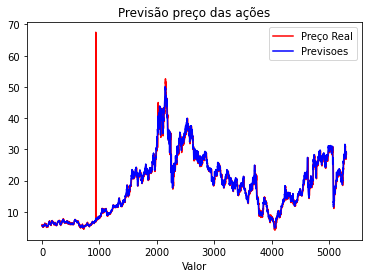

In [ ]:
plt.plot(base.iloc[:,1:2].values, color = 'red', label = 'Preço Real')
plt.plot(previsoes, color = 'blue', label = 'Previsoes')
plt.title('Previsão preço das ações')
plt.xlabel('tempo')
plt.xlabel('Valor')
plt.legend()
plt.show()